In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
from datetime import datetime
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = "/".join(current_path.split("/")[:-2]) + "/"

# location folders
data_in = dirname + "da_data_repo/worldbank-lifeexpectancy/clean/"
data_out = dirname + "da_case_studies/ch08-life-expectancy-income/"
output = dirname + "da_case_studies/ch08-life-expectancy-income/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions 
from py_helper_functions import *

In [4]:
def poly(x, degree=1):
    """
    Fit Polynomial

    These are non orthogonal factors, but it may not matter if
    we only need this for predictions (without interpreting the
    coefficients) or visualisation.
    """
    d = {}
    for i in range(degree+1):
        if i == 1:
            d['x'] = x
        else:
            d[f'x**{i}'] = np.power(x, i)
    return pd.DataFrame(d)


In [5]:
xc = pd.read_csv(
    data_in + "worldbank-lifeexpectancy.csv", sep="\t", engine="python"
).drop("Time Code", axis=1)
xc.columns = [
    "year",
    "countryname",
    "countrycode",
    "gdp_per_capita",
    "population",
    "lifeexp",
]

In [6]:
# Select obs
xc=xc.query('countrycode!=""')
xc=xc.replace("..","")

In [7]:
# CLEAN VARIABLES
xc["population"]=pd.to_numeric(xc['population'])/1000000
xc["gdppc"]=pd.to_numeric(xc['gdp_per_capita'])/1000
xc["lifeexp"]=pd.to_numeric(xc["lifeexp"])

In [8]:
print(xc.shape[0])
print(xc.loc[xc.gdppc.notna()].shape[0])
print(xc.loc[xc.lifeexp.notna()].shape[0])
print(xc.loc[xc.lifeexp.notna()&xc.gdppc.notna()].shape[0])

12803
5410
11329
5029


In [9]:
# DESCRIBE OBSERVATIONS WITH MISSING VALUE

In [10]:
xc.loc[xc.lifeexp.notna()&xc.gdppc.notna(),"population"].describe()

count    5029.000000
mean       34.975093
std       130.651465
min         0.019105
25%         2.034319
50%         7.110001
75%        22.794284
max      1386.395000
Name: population, dtype: float64

In [11]:
xc.loc[xc.lifeexp.isna() | xc.gdppc.isna(), "population"].describe()

count    7666.000000
mean       17.051644
std        75.563468
min         0.003893
25%         0.149863
50%         2.684412
75%         9.583248
max      1392.730000
Name: population, dtype: float64

In [12]:
xc=xc.query("year==2017").query("lifeexp.notna()").query("gdppc.notna()")

In [13]:
# GDP total, log
xc['gdptot']=xc['gdppc']*xc['population']
xc['lngdppc']=np.log(xc['gdppc'])
xc['lngdptot']=np.log(xc['gdptot'])

In [14]:
xc.loc[:,['lifeexp','gdppc','gdptot','lngdppc','lngdptot']].describe()

,lifeexp,gdppc,gdptot,lngdppc,lngdptot
count,182.000000,182.000000,182.000000,182.000000,182.000000
mean,72.307650,19.227860,629.823545,2.371420,4.351424
std,7.648017,20.386738,2218.147072,1.182575,2.186134
min,52.214000,0.670777,0.231175,-0.399318,-1.464581
25%,66.829750,4.444143,22.788201,1.491582,3.126207
50%,73.914000,12.253987,74.441676,2.505850,4.309768
75%,77.402500,27.327675,352.111662,3.307899,5.863881
max,84.680488,113.262182,21148.059722,4.729705,9.959303


In [15]:
###########################################
# Graphs 
###########################################
####################
## PER CAPITA GDP
####################

# HISTOGRAMS

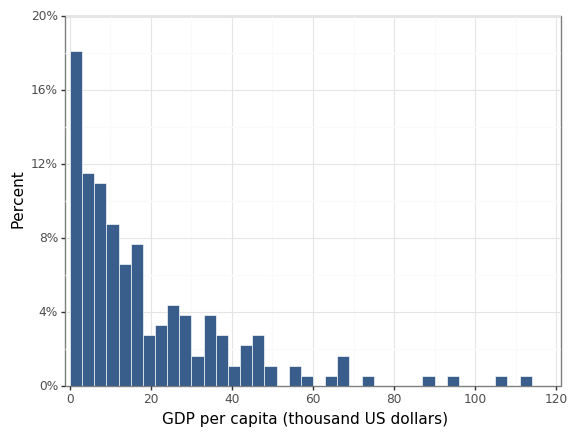

<ggplot: (8783777104755)>

In [16]:
ggplot(xc, aes(x="gdppc", y="stat(count)/sum(stat(count))")) + geom_histogram(
    binwidth=3,
    boundary=0,
    color="white",
    fill=color[0],
    size=0.25,
    alpha=0.8,
    show_legend=False,
    na_rm=True,
) + labs(x="GDP per capita (thousand US dollars)", y="Percent") + expand_limits(
    x=0.01, y=0.01
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 120), breaks=seq(0, 121, 20)
) + scale_y_continuous(
    labels=percent_format(),
    breaks=seq(0, 0.21, 0.04),
    limits=(0, 0.2),
    expand=(0.0, 0.0),
) + theme_bw()

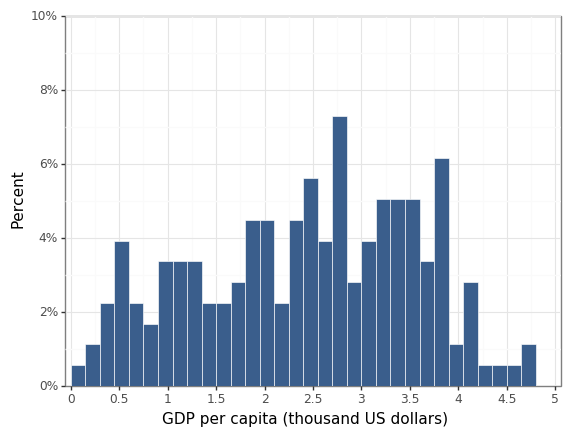

<ggplot: (8783777213630)>

In [17]:
ggplot(xc, aes(x="lngdppc", y="stat(count)/sum(stat(count))")) + geom_histogram(
    binwidth=0.15,
    boundary=0,
    color="white",
    fill=color[0],
    size=0.25,
    alpha=0.8,
    show_legend=False,
    na_rm=True,
) + labs(x="GDP per capita (thousand US dollars)", y="Percent") + expand_limits(
    x=0.01, y=0.01
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 5), breaks=seq(0, 5.1, 0.5)
) + scale_y_continuous(
    expand=(0.0, 0.0),
    limits=(0, 0.1),
    breaks=seq(0, 0.11, 0.02),
    labels=percent_format(),
) + theme_bw()

In [18]:
# LEVEL-LEVEL REGRESSION
reg3=smf.ols(formula='lifeexp ~ gdppc',data=xc)
reg3.fit().summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.439
No. Observations:                 182   F-statistic:                     142.4
Covariance Type:            nonrobust   Prob (F-statistic):           1.47e-24
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     67.5137      0.585    115.478      0.000      66.360      68.667
gdppc          0.2493      0.021     11.933      0.000       0.208       0.291
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

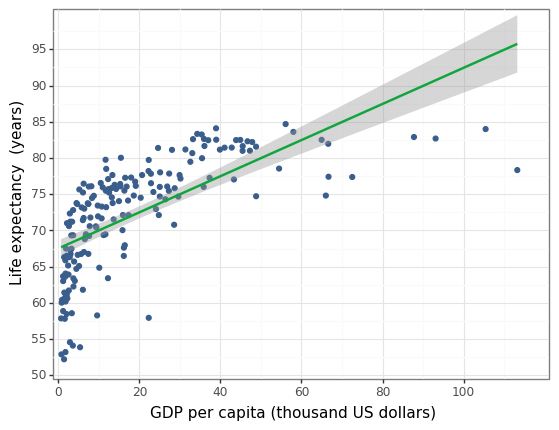

<ggplot: (8783777133713)>

In [19]:
ggplot(xc, aes(x="gdppc", y="lifeexp")) + geom_point(color=color[0]) + geom_smooth(
    color=color[1], method="lm"
) + coord_cartesian(xlim=(0, 120), ylim=(50, 100)) + expand_limits(
    x=0.01, y=0.01
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 120), breaks=seq(0, 120, by=20)
) + scale_y_continuous(
    expand=(0.01, 0.01), breaks=seq(50, 100, by=5)
) + labs(
    x="GDP per capita (thousand US dollars)", y="Life expectancy  (years)"
) + theme_bw()

In [20]:
# LOG GDP PER CAPITA (shown on two scales)
reg4=smf.ols(formula='lifeexp ~ lngdppc',data=xc)
reg4.fit().summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.678
No. Observations:                 182   F-statistic:                     382.8
Covariance Type:            nonrobust   Prob (F-statistic):           2.00e-46
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.6593      0.722     82.628      0.000      58.235      61.084
lngdppc        5.3336      0.273     19.565      0.000       4.796       5.872
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

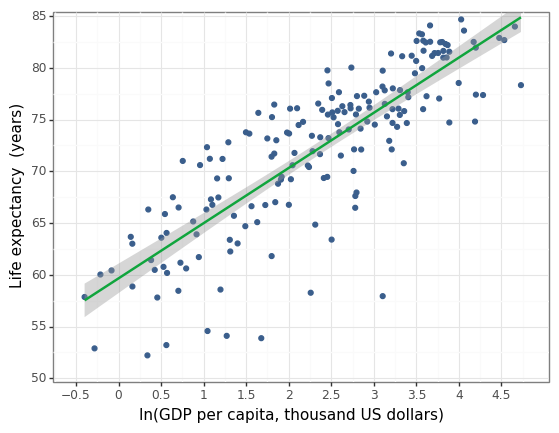

<ggplot: (8783776930826)>

In [21]:
ggplot(xc, aes(x="lngdppc", y="lifeexp")) + geom_point(color=color[0]) + geom_smooth(
    color=color[1], method="lm"
) + coord_cartesian(xlim=(-0.5, 4.8), ylim=(50, 85)) + scale_x_continuous(
    breaks=seq(-0.5, 4.6, by=0.5)
) + scale_y_continuous(
    expand=(0.01, 0.01), breaks=seq(50, 85.1, by=5)
) + labs(
    x="ln(GDP per capita, thousand US dollars) ", y="Life expectancy  (years)"
) + theme_bw()

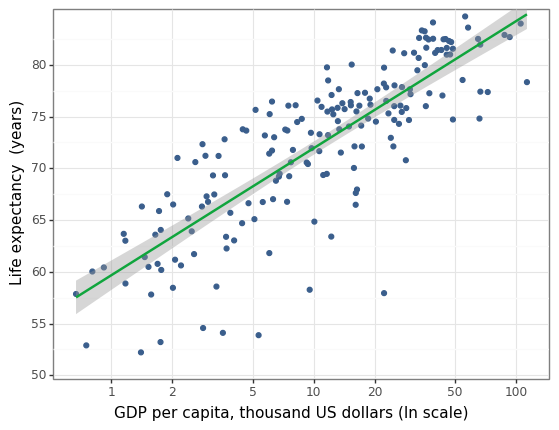

<ggplot: (8783777133611)>

In [22]:
ggplot(xc, aes(x="gdppc", y="lifeexp")) + geom_point(color=color[0]) + geom_smooth(
    color=color[1], method="lm"
) + coord_cartesian(ylim=(50, 85)) + scale_x_continuous(
    trans=transforms.log_trans(), breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100)
) + scale_y_continuous(
    expand=(0.01, 0.01), breaks=seq(50, 85, by=5)
) + labs(
    x="GDP per capita, thousand US dollars (ln scale) ", y="Life expectancy  (years)"
) + theme_bw()

In [23]:
################################
## TOTAL GDP
################################

In [24]:
# LEVEL-LEVEL REGRESSION
reg1=smf.ols(formula='lifeexp ~ gdppc',data=xc)
reg1.fit().summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.439
No. Observations:                 182   F-statistic:                     142.4
Covariance Type:            nonrobust   Prob (F-statistic):           1.47e-24
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     67.5137      0.585    115.478      0.000      66.360      68.667
gdppc          0.2493      0.021     11.933      0.000       0.208       0.291
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

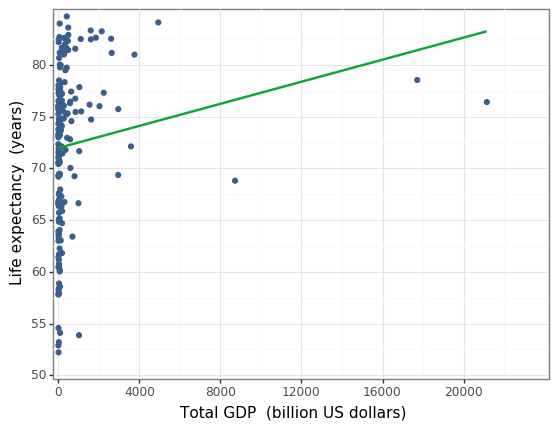

<ggplot: (8783776962091)>

In [25]:
ggplot(xc, aes(x="gdptot", y="lifeexp")) + geom_point(color=color[0]) + geom_smooth(
    color=color[1], method="lm",se=False
) + coord_cartesian(xlim=(0, 24000), ylim=(50, 85)) + expand_limits(
    x=0.01, y=0.01
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 24000), breaks=seq(0, 24000, by=4000)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(50, 85), breaks=seq(50, 85, by=5)
) + labs(
    x="Total GDP  (billion US dollars)", y="Life expectancy  (years)"
) + theme_bw()

In [26]:
reg2=smf.ols(formula='lifeexp ~ lngdptot',data=xc)
reg2.fit().summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.135
No. Observations:                 182   F-statistic:                     29.30
Covariance Type:            nonrobust   Prob (F-statistic):           1.96e-07
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     66.6120      1.177     56.598      0.000      64.290      68.934
lngdptot       1.3089      0.242      5.413      0.000       0.832       1.786
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

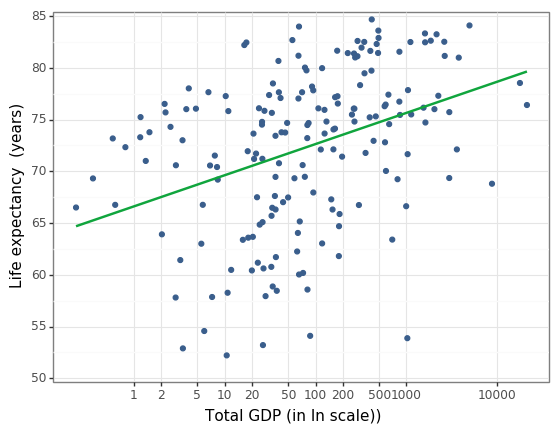

<ggplot: (8783777077941)>

In [27]:
ggplot(xc, aes(x="gdptot", y="lifeexp")) + geom_point(color=color[0]) + geom_smooth(
    color=color[1], method="lm", se=False
) + coord_cartesian(ylim=(50, 85)) + scale_x_continuous(
    trans=transforms.log_trans(),
    breaks=(1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 10000),
) + scale_y_continuous(
    expand=(0.01, 0.01), breaks=(50, 55, 60, 65, 70, 75, 80, 85)
) + labs(
    x="Total GDP (in ln scale))", y="Life expectancy  (years)"
) + theme_bw()

In [28]:
##########################################
# GDP PER CAPITA PIECEWISE LINEAR SPLINE 
##########################################

In [29]:
cutoff=50
cutoff_ln=np.log(cutoff)

In [33]:
reg5=smf.ols(formula="lifeexp ~ lspline(lngdppc,cutoff_ln)",data=xc)
reg5.fit().summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.683
No. Observations:                 182   F-statistic:                     195.9
Covariance Type:            nonrobust   Prob (F-statistic):           8.31e-46
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         59.2872      0.743     79.767      0.000      57.821      60.754
lspline(lngdppc, cutoff_ln)[0]     5.5526      0.294     18.868      0.000       4.972       6.133
lspline(lngdppc, cutoff_ln)[1]    -0.2941      2.981     -0.099      0.922      -6.177       5.588
==================================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
xc['e3']=reg5.fit().resid
xc['sppred']=reg5.fit().predict()

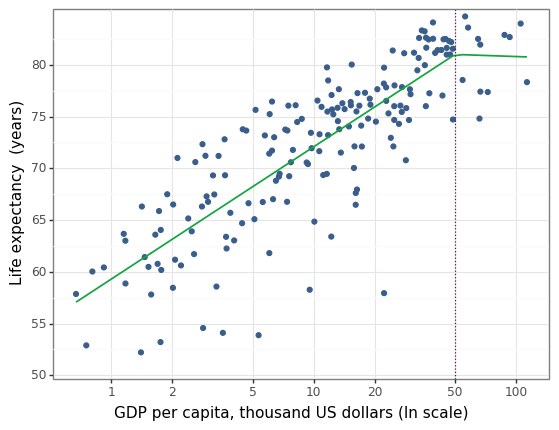

<ggplot: (8783766015476)>

In [51]:
ggplot(xc, aes(x="gdppc", y="lifeexp")) + geom_point(color=color[0]) + geom_line(
    xc, aes(x="gdppc", y="sppred"), color=color[1], size=0.7
) + geom_vline(
    xintercept=cutoff, color=color[2], size=0.5, linetype="dotted"
) + coord_cartesian(
    ylim=(50, 85)
) + scale_x_continuous(
    trans=transforms.log_trans(), breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100)
) + scale_y_continuous(
    expand=(0.01, 0.01), breaks=seq(50, 85, by=5)
) + labs(
    x="GDP per capita, thousand US dollars (ln scale) ", y="Life expectancy  (years)"
) + theme_bw()

In [29]:
# QUADRATIC IN LEVEL-LOG REGRESSION
xc['lngdppc_sq']=xc['lngdppc'].pow(2)
reg6=smf.ols(formula='lifeexp ~ lngdppc+lngdppc_sq',data=xc)
reg6.fit().summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.678
No. Observations:                 182   F-statistic:                     192.0
Covariance Type:            nonrobust   Prob (F-statistic):           2.92e-45
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.9017      1.035     56.911      0.000      56.859      60.944
lngdppc        6.3038      0.988      6.380      0.000       4.354       8.254
lngdppc_sq    -0.2200      0.215     -1.022      0.308      -0.645       0.205
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
xc['e6']=reg6.fit().resid

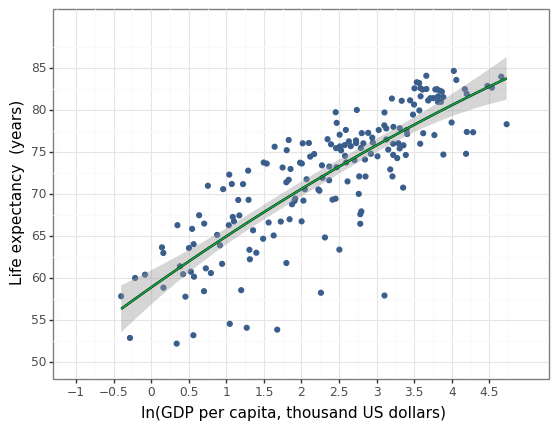

<ggplot: (8756878791476)>

In [31]:
ggplot(xc, aes(x="lngdppc", y="lifeexp")) + geom_point(color=color[0]) + stat_smooth(
    method="lm", formula="y~poly(x,degree=2)"
) + stat_smooth(
    color=color[1], method="lm", formula="y ~ poly(x,2)", se=False, size=0.7
) + coord_cartesian(
    xlim=(-1, 5), ylim=(50, 90)
) + scale_x_continuous(
    breaks=seq(-1, 5, by=0.5)
) + scale_y_continuous(
    breaks=seq(50, 90, by=5)
) + labs(
    x="ln(GDP per capita, thousand US dollars)", y="Life expectancy  (years)"
) + theme_bw()

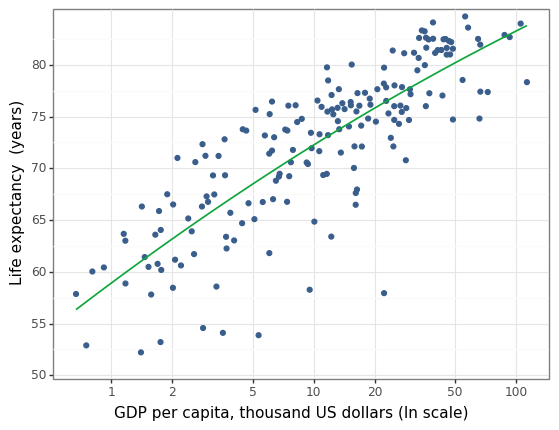

<ggplot: (8756917679403)>

In [32]:
ggplot(xc, aes(x="gdppc", y="lifeexp")) + geom_point(color=color[0]) + stat_smooth(
    color=color[1], method="lm", formula="y ~ poly(x,2)", se=False, size=0.7
) + coord_cartesian(ylim=(50, 85)) + scale_x_continuous(
    trans=transforms.log_trans(), breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100)
) + scale_y_continuous(
    expand=(0.01, 0.01), breaks=seq(50, 85, by=5)
) + labs(
    x="GDP per capita, thousand US dollars (ln scale) ", y="Life expectancy  (years)"
) + theme_bw()

In [33]:
# WEIGHTED AND UNWEIGHTED REGRESSION
########################################

In [34]:
reg7=smf.ols(formula='lifeexp ~ lngdppc',data=xc)
reg7.fit().summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.678
No. Observations:                 182   F-statistic:                     382.8
Covariance Type:            nonrobust   Prob (F-statistic):           2.00e-46
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.6593      0.722     82.628      0.000      58.235      61.084
lngdppc        5.3336      0.273     19.565      0.000       4.796       5.872
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
reg7=smf.wls(formula='lifeexp ~ lngdppc',data=xc,weights=xc.population)
reg7.fit().summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.662
Model:                            WLS   Adj. R-squared:                  0.660
No. Observations:                 182   F-statistic:                     351.9
Covariance Type:            nonrobust   Prob (F-statistic):           3.23e-44
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.7179      0.775     75.716      0.000      57.188      60.248
lngdppc        5.7529      0.307     18.760      0.000       5.148       6.358
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

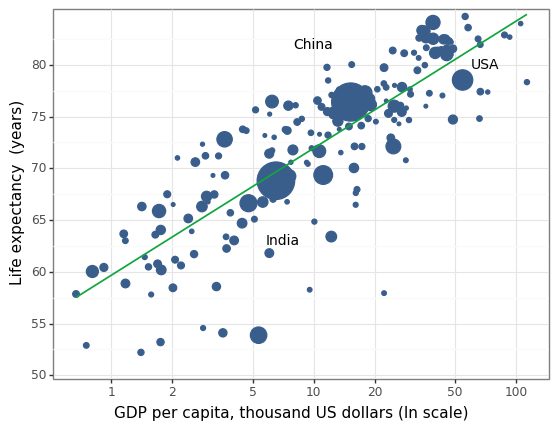

<ggplot: (8756879070913)>

In [36]:
ggplot(xc, aes(x="gdppc", y="lifeexp")) + geom_point(
    xc, aes(size="population"), color=color[0], alpha=0.6, show_legend=False
) + geom_smooth(
    aes(weight="population"), method="lm", color=color[1], se=False, size=0.7
) + scale_size(
    range=(1, 15)
) + coord_cartesian(
    ylim=(50, 85)
) + scale_x_continuous(
    trans=transforms.log_trans(), breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100)
) + scale_y_continuous(
    expand=(0.01, 0.01), breaks=seq(50, 85, by=5)
) + labs(
    x="GDP per capita, thousand US dollars (ln scale) ", y="Life expectancy  (years)"
) + theme_bw() + annotate(
    "text", x=70, y=80, label="USA", size=10
) + annotate(
    "text", x=10, y=82, label="China", size=10
) + annotate(
    "text", x=7, y=63, label="India", size=10
)

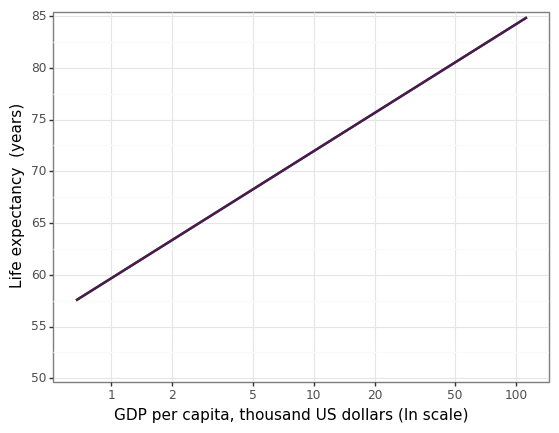

<ggplot: (8756878771222)>

In [37]:
#### weighting is not working
ggplot(xc, aes(x="gdppc", y="lifeexp")) + geom_smooth(
    method="lm", color=color[1], se=False, size=1
) + geom_smooth(
    aes(weight="population"),method="lm", color=color[2], se=False, size=1
) + scale_size(
    range=(1, 15)
) + coord_cartesian(
    ylim=(50, 85)
) + scale_x_continuous(
    trans=transforms.log_trans(), breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100)
) + scale_y_continuous(
    expand=(0.01, 0.01), breaks=seq(50, 86, by=5)
) + labs(
    x="GDP per capita, thousand US dollars (ln scale) ", y="Life expectancy  (years)"
) + theme_bw()

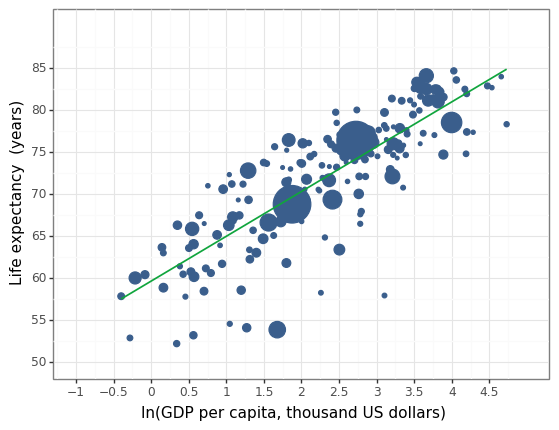

<ggplot: (8756878929288)>

In [38]:
ggplot(xc, aes(x="lngdppc", y="lifeexp")) + geom_point(
    xc, aes(size="population"), color=color[0], alpha=0.4, show_legend=False
) + geom_smooth(
    aes(weight="population"), method="lm", color=color[1], se=False, size=0.7
) + scale_size(
    range=(1, 15)
) + coord_cartesian(
    xlim=(-1, 5), ylim=(50, 90)
) + scale_x_continuous(
    breaks=seq(-1, 5, by=0.5)
) + scale_y_continuous(
    breaks=seq(50, 90, by=5)
) + labs(
    x="ln(GDP per capita, thousand US dollars)",
    y="Life expectancy  (years)",
    size="Population",
) + theme_bw()